In [1]:
using CSV
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables
using Random

using BSON: @save
using BSON: @load

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

In [2]:
train_new_model = false

false

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_raw_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [5]:
first(x_raw_df, 5)

Row,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9,DVAR10,DVAR11,DVAR12,DVAR13,DVAR14
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,10.7561,51.3217,117.941,1.58493,1.80198,54.7152,46.9082,-73.5071,-40.3815,138.785,351.531,1.93865,-25.7427,0.06066
2,10.9999,59.0984,114.967,1.42384,1.632,94.2397,329.885,-69.9227,-61.021,106.547,437.766,1.93494,-23.1017,0.05759
3,10.5114,67.2372,102.822,1.56805,1.76104,232.236,482.175,-34.481,-31.0546,207.38,301.455,1.97332,-20.3739,0.05913
4,9.79078,132.062,157.89,1.06108,1.4818,91.7427,178.76,-35.0063,-28.2593,342.114,83.4083,1.6819,-25.0504,0.07113
5,10.8851,33.3697,144.044,1.67219,1.83251,433.296,420.627,-32.8443,-26.0774,477.253,152.462,1.94816,-20.8219,0.06301


In [6]:
first(y_raw_df, 5)

Row,OBJ1,OBJ2,OBJ3,OBJ4,OBJ5,OBJ6
,Float32,Float32,Float32,Float32,Float32,Float32
1,91.0,0.0624,99.34,0.07639,0.07035,0.05352
2,92.69,0.0579,110.26,0.07544,0.03639,0.05048
3,70.87,0.0649,80.55,0.07192,0.04194,0.02244
4,16.85,0.0756,183.99,0.01274,0.01483,0.01153
5,66.16,0.0674,56.7,0.06682,0.03004,0.04468


## EDA

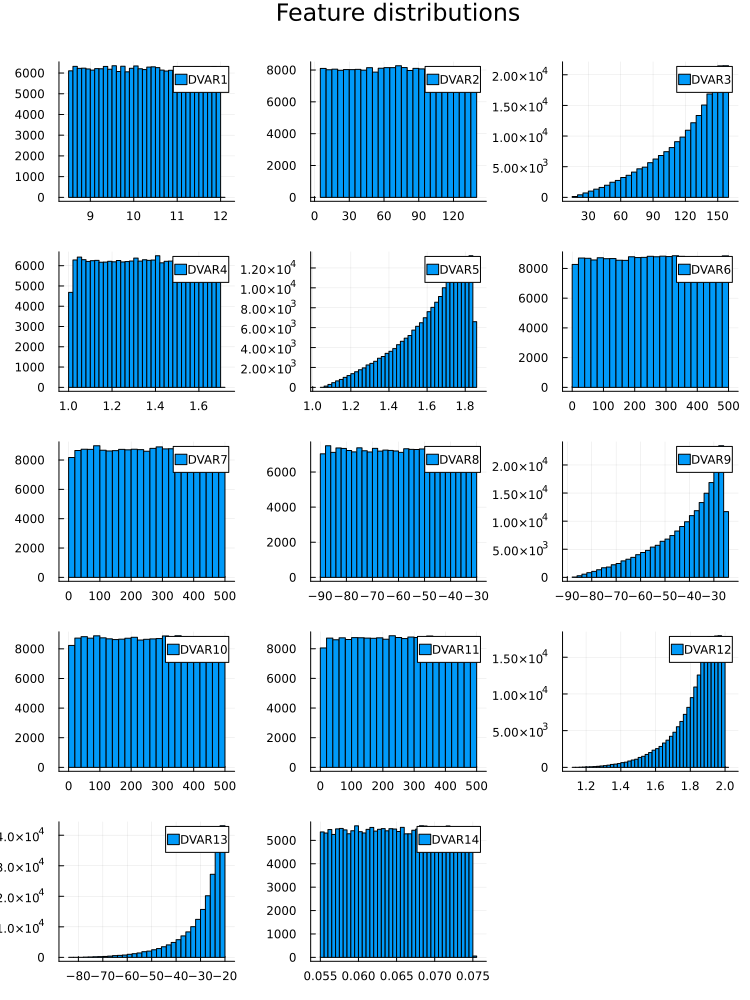

In [7]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_raw_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

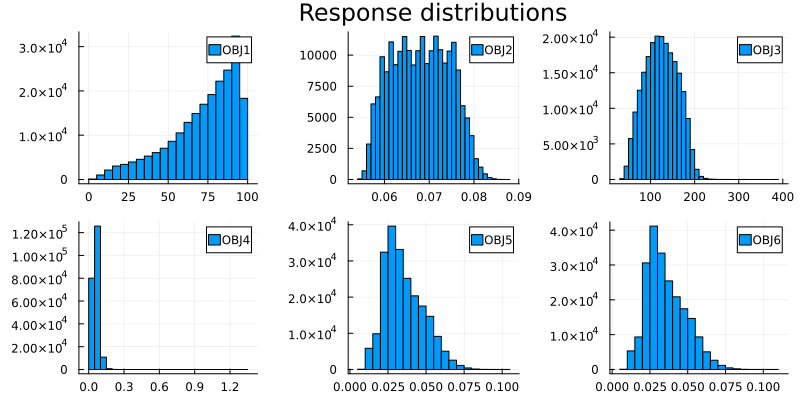

In [8]:
# plot responses
l = @layout [grid(2,3)]

subplots = []
for i in 1:6
    hist = histogram(y_raw_df[:, "OBJ$i"], label="OBJ$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout = l, size=(800, 400), plot_title="Response distributions")

In [9]:
# some cuts
# abnormally_high_rfq_length = 220. # OBJ3
# abnormally_high_longitudinal_emittance = 1.2 # OBJ4
# abnormally_high_x_emittance = 0.12 # OBJ5
# abnormally_high_y_emittance = 0.12 # OBJ6
abnormally_low_transmission = 50 # OBJ1

# non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
#                           (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
#                           (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
#                           (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

non_outlier_conditional = (y_raw_df[:, "OBJ1"] .>= abnormally_low_transmission)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [10]:
# how many outliers are there?
sum((!).(non_outlier_conditional))

36589

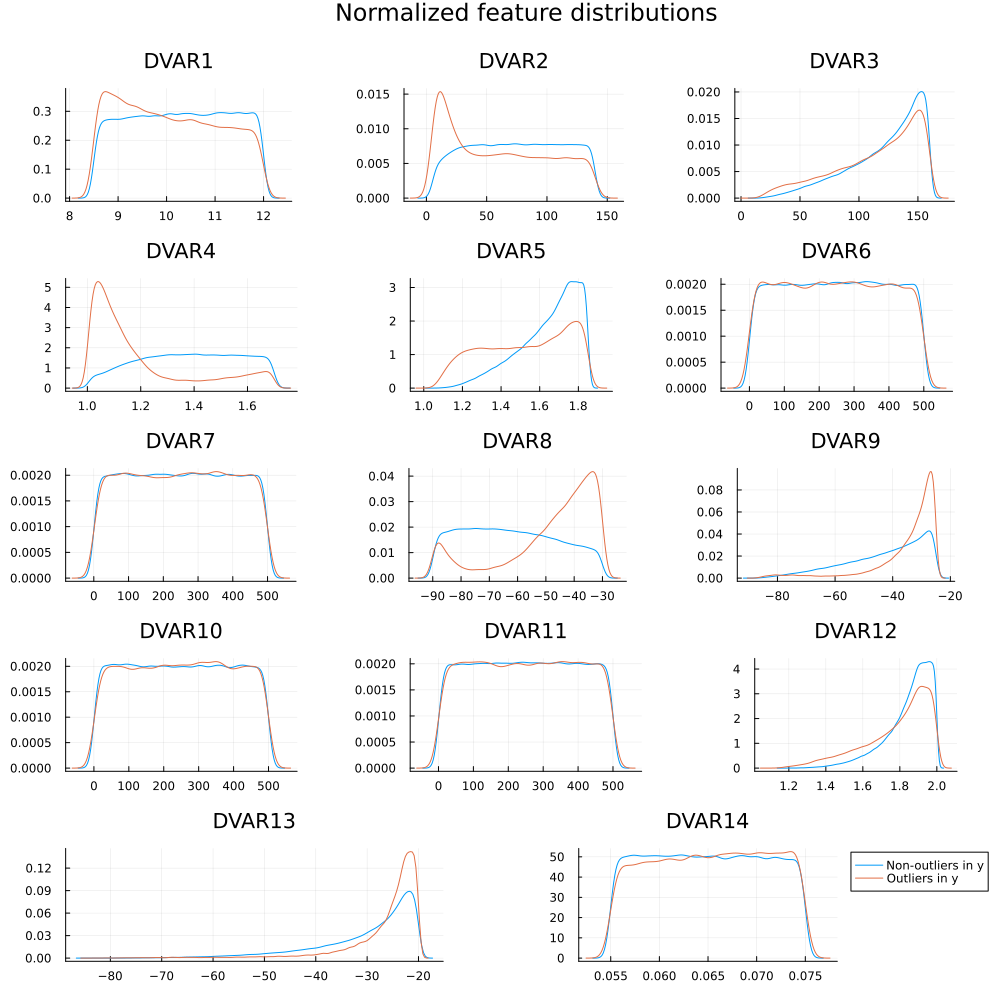

In [11]:
# features split by outlier
l = @layout [a b c; d e f; g h i; j k l; m n]

subplots = []
for i in 1:14
    sp = density(x_df[:, "DVAR$i"]; label=(i == 14 ? "Non-outliers in y" : ""), legend=(i==14), title="DVAR$i")
    density!(sp, x_outliers_df[:, "DVAR$i"]; label=(i == 14 ? "Outliers in y" : ""), legend=:outertopright)
    push!(subplots, sp)
end

plot(subplots..., layout=l, size=(1000, 1000), plot_title="Normalized feature distributions")

## Data preprocessing

In [12]:
function getdvarprime(data_to_transform, dynamic_lower_bound, strict_upper_bound)
    (data_to_transform .- dynamic_lower_bound) ./ (strict_upper_bound .- dynamic_lower_bound)
end

function decorrelatedvars(df_raw)
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )

    DataFrame(
        "DVAR1"=>df_raw[:, "DVAR1"],
        "DVAR2"=>df_raw[:, "DVAR2"],
        "DVAR3"=>getdvarprime(df_raw[:, "DVAR3"], etas["DVAR3"] .+ df_raw[:, "DVAR2"], maxes["DVAR3"]),
        "DVAR4"=>df_raw[:, "DVAR4"],
        "DVAR5"=>getdvarprime(df_raw[:, "DVAR5"], etas["DVAR5"] .+ df_raw[:, "DVAR4"], maxes["DVAR5"]),
        "DVAR6"=>df_raw[:, "DVAR6"],
        "DVAR7"=>df_raw[:, "DVAR7"],
        "DVAR8"=>df_raw[:, "DVAR8"],
        "DVAR9"=>getdvarprime(df_raw[:, "DVAR9"], etas["DVAR9"] .+ df_raw[:, "DVAR8"], maxes["DVAR9"]),
        "DVAR10"=>df_raw[:, "DVAR10"],
        "DVAR11"=>df_raw[:, "DVAR11"],
        "DVAR12"=>getdvarprime(df_raw[:, "DVAR12"], etas["DVAR12"] .+ df_raw[:, "DVAR5"], maxes["DVAR12"]),
        "DVAR13"=>getdvarprime(df_raw[:, "DVAR13"], etas["DVAR13"] .+ df_raw[:, "DVAR9"], maxes["DVAR13"]),
        "DVAR14"=>df_raw[:, "DVAR14"]
    )
end

decorrelatedvars (generic function with 1 method)

In [13]:
x_df = decorrelatedvars(x_df);

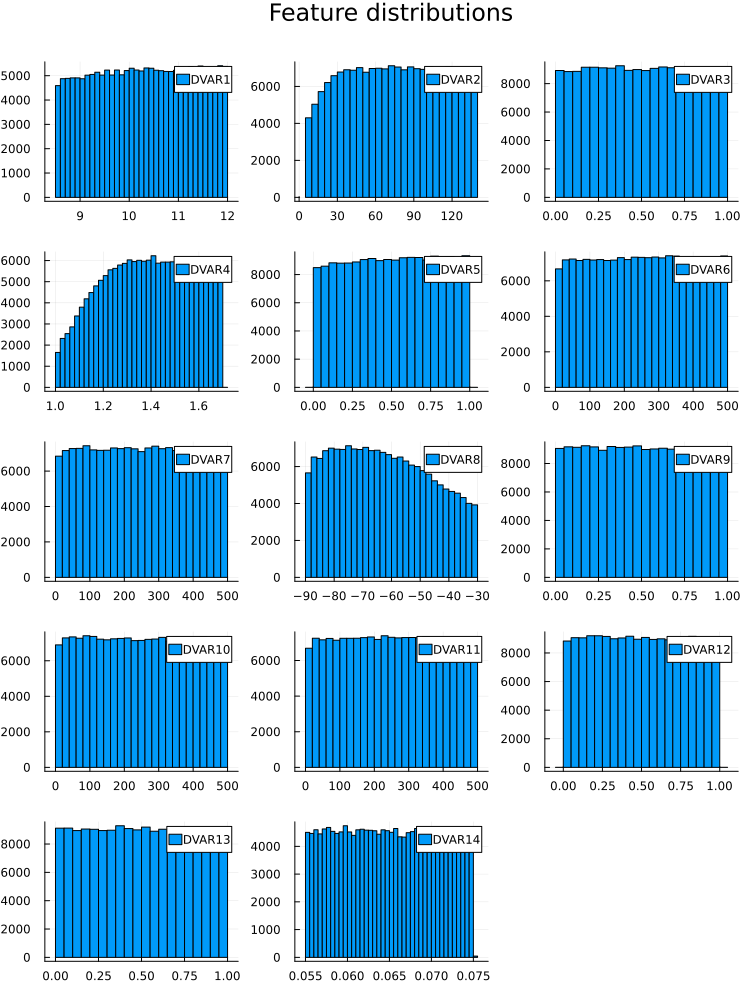

In [14]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

In [15]:
# drop any columns needed
select!(x_df, Not(x_columns_to_drop));
select!(y_df, Not(y_columns_to_drop));

In [16]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [17]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [18]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [19]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [20]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [21]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [22]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "../models/2022-11-09_17-51-27_w=100_d=5_activation=sigmoid_bs=1024_lr=0.001_dr=0.0_1.bson" m
end

LoadError: too many parameters for type

In [23]:
# plot training history
# plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [24]:
# # rsquared
# function r2score(yvec, ŷvec)
#     ymean = mean(yvec)
#     numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
#     denominator = sum((y - ymean)^2 for y in yvec)
#     1 - numerator / denominator
# end
    
# function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
#     d = size(ys, 2)
#     r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
#     if multioutput == "rawvalues"
#         return r2score_rawvalues
#     elseif multioutput == "uniformaverage"
#         return mean(r2score_rawvalues)
#     else
#         error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
#     end
# end

In [25]:
# r2_train = r2score_multidim(y_train, m(x_train')')
# r2_test = r2score_multidim(y_test, m(x_test')')
# println("r2 on training set: $r2_train")
# println("r2 on test set: $r2_test")

In [26]:
# # adjusted rsquared
# function adjustedr2score(yvec, ŷvec, p::Int)
#     M = size(yvec, 1)
#     return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
# end

# function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
#     d = size(ys, 2)
#     adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
#     if multioutput == "rawvalues"
#         return adjustedr2score_rawvalues
#     elseif multioutput == "uniformaverage"
#         return mean(adjustedr2score_rawvalues)
#     else
#         error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
#     end
# end

In [27]:
# adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
# adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
# println("adjustedr2 on training set: $adjustedr2_train")
# println("adjustedr2 on test set: $adjustedr2_test")

In [28]:
# mae_train = Flux.mae(m(x_train')', y_train)
# mae_test = Flux.mae(m(x_test')', y_test)
# println("mae on training set: $mae_train")
# println("mae on test set: $mae_test")

In [29]:
# # mae for each response
# y_train_preds = m(x_train')'
# y_test_preds = m(x_test')'

# for i in 1:y_dimension
#     mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
#     mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
#     println("mae on training set for OBJ$i: $mae_train_by_dim")
#     println("mae on test set for OBJ$i: $mae_test_by_dim")
# end

In [30]:
# #=== redefine minmaxscaler for now ===#
# function minmax_fit!(scaler, data)
#     scaler.data_min = minimum(data); scaler.data_max = maximum(data)
# end

# function minmax_transform(scaler, data)
#     [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
# end

# function minmax_inverse_transform(scaler, data_scaled)
#     [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
# end

# function minmax_fit_transform(data)
#     scaler = MinMaxScaler(0., 0.)
#     minmax_fit!(scaler, data)
#     minmax_transform(scaler, data)
# end

In [31]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [32]:
# # mape for each response
# for i in 1:y_dimension
#     temp_train_preds_normalized = y_train_preds[:, i]
#     temp_train_trues_normalized = y_train[:, i]
    
#     temp_test_preds_normalized = y_test_preds[:, i]
#     temp_test_trues_normalized = y_test[:, i]
    
#     # unnormalize
#     y_scaler = MinMaxScaler(0., 0.)
#     minmax_fit!(y_scaler, y_df[!, "OBJ$i"])
    
#     temp_train_preds_original = minmax_inverse_transform(y_scaler, temp_train_preds_normalized)
#     temp_train_trues_original = minmax_inverse_transform(y_scaler, temp_train_trues_normalized)
#     temp_test_preds_original = minmax_inverse_transform(y_scaler, temp_test_preds_normalized)
#     temp_test_trues_original = minmax_inverse_transform(y_scaler, temp_test_trues_normalized)
    
#     # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
#     println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
# end

**Summary**

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

In [33]:
# plotting the residual distribution for full data set
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals = y_df - m(x_df')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
#     density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

LoadError: MethodError: no method matching adjoint(::DataFrame)
[0mClosest candidates are:
[0m  adjoint([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m) at C:\Users\Daniel Winklehner\AppData\Local\Programs\Julia-1.8.2\share\julia\stdlib\v1.8\LinearAlgebra\src\qr.jl:517
[0m  adjoint([91m::Union{Cholesky, CholeskyPivoted}[39m) at C:\Users\Daniel Winklehner\AppData\Local\Programs\Julia-1.8.2\share\julia\stdlib\v1.8\LinearAlgebra\src\cholesky.jl:558
[0m  adjoint([91m::WoodburyMatrices.SymWoodbury{T}[39m) where T<:Real at C:\Users\Daniel Winklehner\.julia\packages\WoodburyMatrices\zexu7\src\symwoodbury.jl:153
[0m  ...

In [34]:
# residuals as a function of scaled objective value for full data set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_df[:, i], residuals[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

LoadError: MethodError: no method matching getindex(::typeof(residuals), ::Colon, ::Int64)

In [35]:
# residuals as a function of scaled objective value, test set
# l = @layout [grid(2,3)]

# subplots = []
# for (i, colname) in enumerate(y_columns)
#     sp = histogram2d(
#         y_test[:, i], residuals_test[:, i];
#         xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
#         title="$colname", bins=(60, 60)
#     )
#     push!(subplots, sp)
# end

# plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")